# **Data Cleaning**

## Objectives

* The purpose of this notebook is to:
    * Evaluate the missing data levels
    * Clean our dataset

## Inputs

* outputs/datasets/collection/HousePriceRecords.csv

## Outputs

* We will generate cleaned Train and Tests sets in this notebook and save to *outputs/datasets/cleaned*

## CRISP-DM

* Data Preperation 

## Conclusions

* We will take the following actions:
    * Arbitrary Imputation: '2ndFlrSF', 'EnclosedPorch', 'WoodDeckSF'
    * Median Imputation: BedroomAbvGr', 'LotFrontage', 'GarageYrBlt', 'MasVnrArea'
    * Most Frequent Imputation: 'BsmtFinType1', 'GarageFinish'


---

# Change working directory

* The notebooks are stored in a sub folder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/milestone-project-heritage-housing-issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/milestone-project-heritage-housing-issues'

# Load collected dataset

In [4]:
import pandas as pd
df = pd.read_csv(f"outputs/datasets/collection/HousePriceRecords.csv")
df.head(10)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000
5,796,566.0,1.0,No,732,GLQ,64,NaN,480,Unf,...,85.0,0.0,30,5,5,796,NaN,1993,1995,143000
6,1694,0.0,3.0,Av,1369,GLQ,317,NaN,636,RFn,...,75.0,186.0,57,5,8,1686,NaN,2004,2005,307000
7,1107,983.0,3.0,Mn,859,ALQ,216,NaN,484,NaN,...,NaN,240.0,204,6,7,1107,NaN,1973,1973,200000
8,1022,752.0,2.0,No,0,Unf,952,NaN,468,Unf,...,51.0,0.0,0,5,7,952,NaN,1931,1950,129900
9,1077,0.0,2.0,No,851,GLQ,140,NaN,205,RFn,...,50.0,0.0,4,6,5,991,NaN,1939,1950,118000


---

# Data Exploration: Missing Data

* First, we want to identify any variables with missing data
    * Code taken from *CI Walkthrough Project: Churnometer; Data Cleaning*

In [5]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
df.filter(vars_with_missing_data).info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   2ndFlrSF       1374 non-null   float64
 1   BedroomAbvGr   1361 non-null   float64
 2   BsmtFinType1   1346 non-null   object 
 3   EnclosedPorch  136 non-null    float64
 4   GarageFinish   1298 non-null   object 
 5   GarageYrBlt    1379 non-null   float64
 6   LotFrontage    1201 non-null   float64
 7   MasVnrArea     1452 non-null   float64
 8   WoodDeckSF     155 non-null    float64
dtypes: float64(7), object(2)
memory usage: 102.8+ KB


* We want to inspect these variables more closely
* We generate a profile report in order to check the shape and distribution of variables with missing data

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
profile.to_notebook_iframe()

# Assessing Missing Data Levels

* Custom function to display missing data levels in a dataframe, it shows the aboslute levels, relative levels and data type
    * Taken from *Churnometer Data Cleaning notebook*

In [9]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                          data={"RowsWithMissingData": missing_data_absolute,
                                "PercentageOfDataset": missing_data_percentage,
                                "DataType": df.dtypes}
                    )
                    .sort_values(by=['PercentageOfDataset'], ascending=False)
                    .query("PercentageOfDataset > 0")
                    )

    return df_missing_data

* We check the missing levels of our dataset

In [10]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


# Dealing with our missing data

* ### We have quite a few variables with missing data and varying levels of missing data across these variables. Therefore, we will be taking a few different approaches to handling the missing data.

### Arbitrary Number Imputation

* 'EnclosedPorch', 'WoodDeckSF' & '2ndFlrSF' will be handled with an arbitrary Number Imputation of 0. Having studied the pandas Profile Report, I present the rationale below:

    1. 5.9% of the rows are missing data for '2ndFlrSF'. This is not a particularly high amount. The median value of the rows with non-missing rows is 0 and this value represents 53% of the entire variable in this dataset. A value of 0 seems to indicate that the property has no second floor. Missing values may also mean there is no second floor and as the missing level is relativley low, we will arbitrarily impute 0.
    2. 'EnclosedPorch' & 'WoodDeckSF' have very high levels of missing data, 90.7% & 89.4% respectively. Similarly in these cases, missing data may indicate that there is no Porch or no Wood Deck on the property. Considering solely non-missing data, 79% of 'EnclosedPorch' has a value of 0 and over 50% of 'WoodDeckSF' has a value of 0. The indication is that a high number of properties have neither of these features and so we could arbitrarily impute 0.


In [11]:
arbitrary_imputation_vars = ['2ndFlrSF', 'EnclosedPorch', 'WoodDeckSF']
arbitrary_imputation_vars

['2ndFlrSF', 'EnclosedPorch', 'WoodDeckSF']

In [12]:
from feature_engine.imputation import ArbitraryNumberImputer
arbitrary_imputer = ArbitraryNumberImputer(arbitrary_number=0,
                                           variables=arbitrary_imputation_vars)
df_cleaned = df.copy()
df_cleaned = arbitrary_imputer.fit_transform(df_cleaned)
df_cleaned.filter(arbitrary_imputation_vars).info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   2ndFlrSF       1460 non-null   float64
 1   EnclosedPorch  1460 non-null   float64
 2   WoodDeckSF     1460 non-null   float64
dtypes: float64(3)
memory usage: 34.3 KB


## Median Imputation

* 'BedroomAbvGr', 'LotFrontage' & 'MasVnrArea' will be handled with a median imputation method. Having studied the pandas Profile Report, I will present the rationales below:

    1. 'MasVnrArea' has only 8 missing rows and the median value, 0, accounts for almost 69% of this variable. It appears safe to impute the median value for the 8 missing rows of data.

    2. 'BedroomAbvGr' also has a relatively low level of missing rows (6.8%). This variables histogram has quite a normal distribution, so a mean imputation may be advisable but the mean and median are both 3 when the mean is rounded to the nearest whole number, so we use median imputation with the other variables.

    3. 'GarageYrBlt' has a relatively low level of missing rows (5.5%). We notice that exactly 5.5% of values for 'GarageArea' equal zero. This suggests that missing 'GarageYrBlt' values correspond to properties with no garage. Some of these properties will have been built after 1980 and therefore in real world terms, imputing the median which is 1980 does not make sense. However, if these properties do not have garages, then there is no point in arbitrarily imputing a different false value, so we choose median imputation.
    
    3. 'LotFrontage' has a higher level of missing values (17.7%). There are no zero values however which seems to rule out a missing value possibly equalling 0. Judging from the histogram and skew levels, this variable is quite skewed so median imputation seems the best option in this case.

In [13]:
median_imputation_vars = ['BedroomAbvGr', 'LotFrontage', 'GarageYrBlt',
                          'MasVnrArea']
median_imputation_vars

['BedroomAbvGr', 'LotFrontage', 'GarageYrBlt', 'MasVnrArea']

In [14]:
from feature_engine.imputation import MeanMedianImputer
median_imputer = MeanMedianImputer(imputation_method='median',
                                   variables=median_imputation_vars)
df_cleaned = median_imputer.fit_transform(df_cleaned)
df_cleaned.filter(median_imputation_vars).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   BedroomAbvGr  1460 non-null   float64
 1   LotFrontage   1460 non-null   float64
 2   GarageYrBlt   1460 non-null   float64
 3   MasVnrArea    1460 non-null   float64
dtypes: float64(4)
memory usage: 45.8 KB


## Impute Most Frequest

* We have two categorical variables, 'BsmtFinType1' & 'GarageFinish', with missing data. Our imputation method to handle this missing data will be to replace the missing values with the most frequent value in these columns. 

* We will use CategoricalImputer. 

In [15]:
categorical_imputation_vars = ['BsmtFinType1', 'GarageFinish']
categorical_imputation_vars

['BsmtFinType1', 'GarageFinish']

In [16]:
from feature_engine.imputation import CategoricalImputer
categorical_imputer = CategoricalImputer(imputation_method='frequent',
                                         variables=categorical_imputation_vars)
df_cleaned = categorical_imputer.fit_transform(df_cleaned)
df_cleaned.filter(categorical_imputation_vars).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   BsmtFinType1  1460 non-null   object
 1   GarageFinish  1460 non-null   object
dtypes: object(2)
memory usage: 22.9+ KB


#### Sidenote:
* For 'GarageFinish', a custom approach was considered under the following rationale:
    * *It was suggested above that if 'GarageArea' is equal to 0, that the property represented by that row does not have a garage. Therefore, if a row contains missing data for 'GarageFinish', but also 'GarageArea' is equal to 0, we will replace the misssing value with 'None'. Otherwise, we will replace it with the most frequent value which is 'Unf'.*
* The below approach was tested:

* We gathered which index values correspond to rows with missing values for 'GarageFinish' and add them to a list.

In [17]:
nan_GarageFinish_vals = df[df['GarageFinish'].isna()]
nan_GarageFinish_index = list(nan_GarageFinish_vals.index.values)

* We converted missing values to 0, in order to replace them with our preferred values.
* We declared garage_area_value as the value for 'GarageArea' for any given row and iterate through our list of index values.
* If there is no garage, 'GarageArea' is equal to zero, we set 'GarageFinish' to 'None', otherwise we set it to 'Unf', the most frequent value.

In [18]:
df_aside = df_cleaned.copy()
df_aside['GarageFinish'] = df_aside['GarageFinish'].fillna(0)

for x in nan_GarageFinish_index:
    garage_area_value = df.iloc[x, 8]
    if garage_area_value == 0:
        df_aside.at[x, 'GarageFinish'] = 'None'
    else:
        df_aside.at[x, 'GarageFinish'] = 'Unf'

* We checked that there are no missing values

In [19]:
df_aside.filter(['GarageFinish']).value_counts()

GarageFinish
Unf             700
RFn             366
Fin             313
None             81
dtype: int64

* We will assess the missing Data levels on our cleaned Dataframe
    * Custome function DataCleaningEffect taken from *Feature Engine Unit 9: Custom Functions*

In [20]:
EvaluateMissingData(df_aside)

,RowsWithMissingData,PercentageOfDataset,DataType


* A customer imputer was considered but during testing of 'v1' pipeline, it was found that simply imputing the most frequent variable was more effective in predictions than the 'more realistic' custom approach, so we are progressing with the 'most frequent' approach.

## Assessing effect of Data Cleaning


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['2ndFlrSF', 'BedroomAbvGr', 'BsmtFinType1', 'EnclosedPorch', 'GarageFinish', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea', 'WoodDeckSF'] 




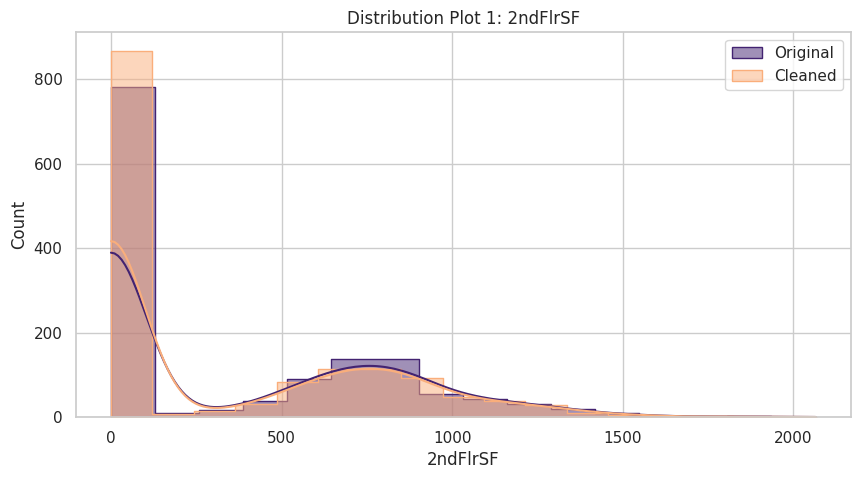

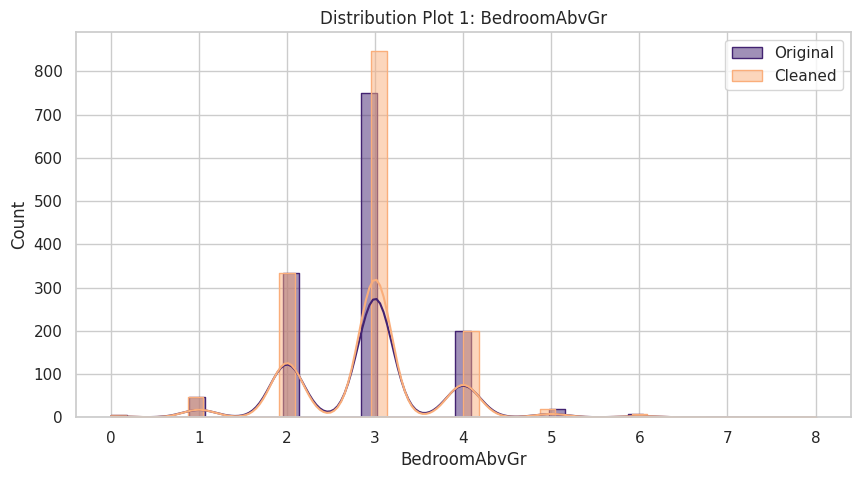

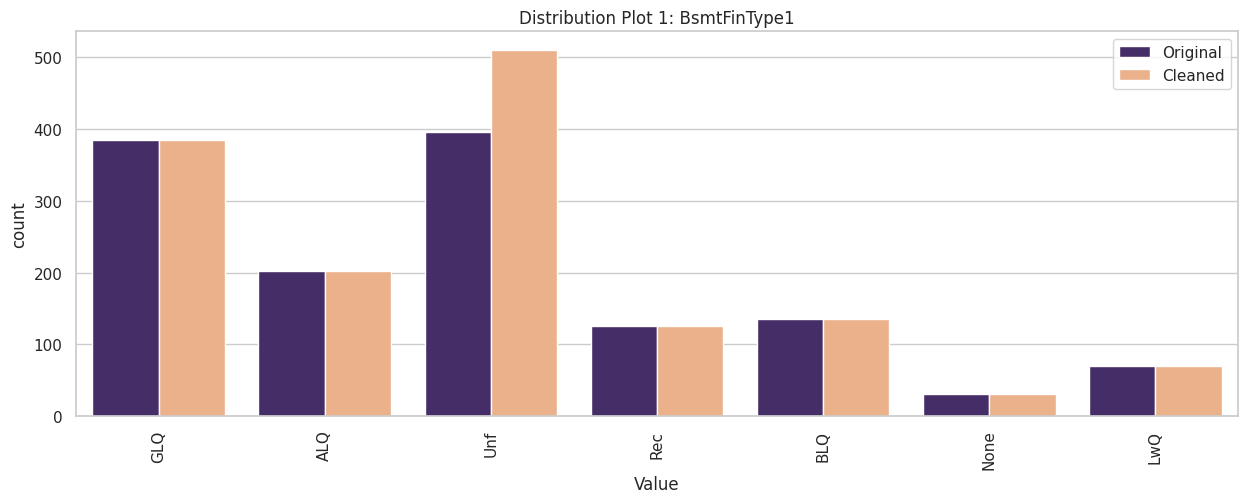

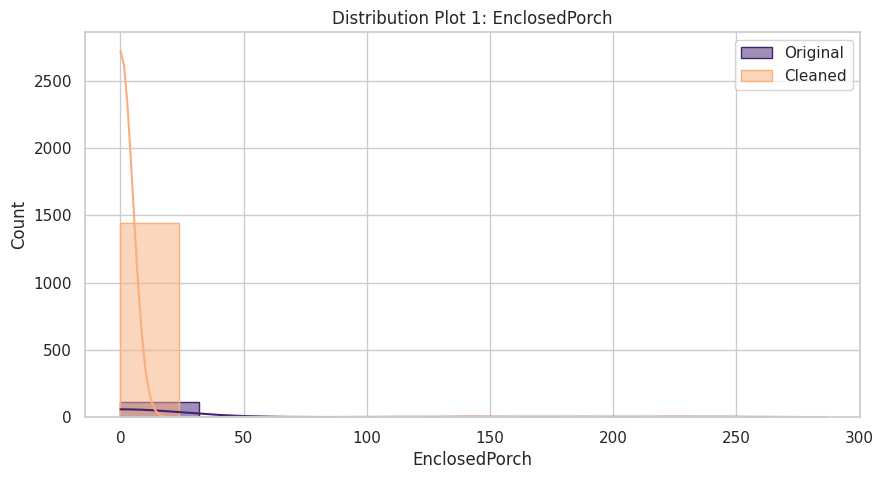

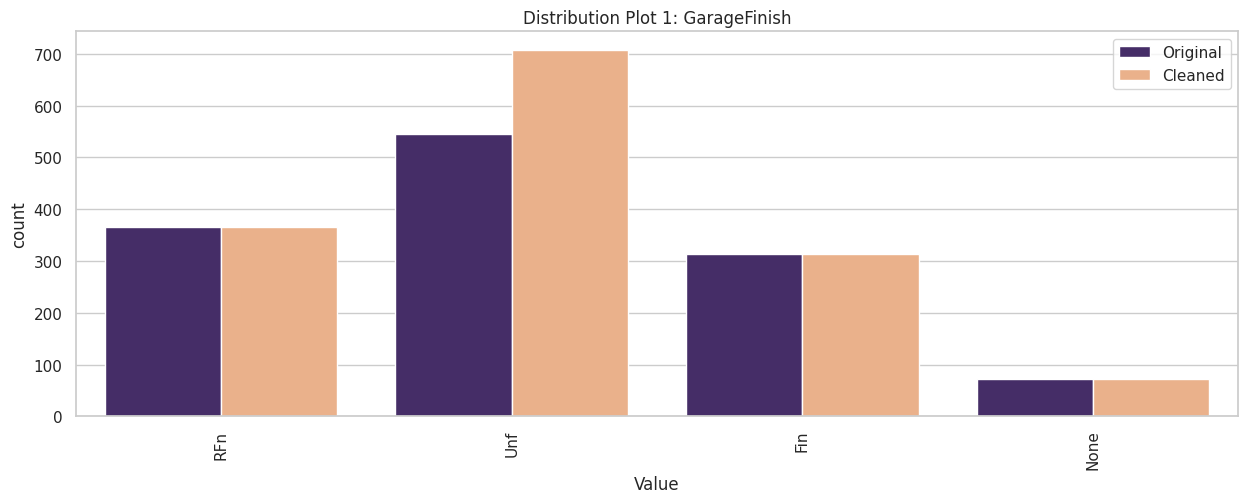

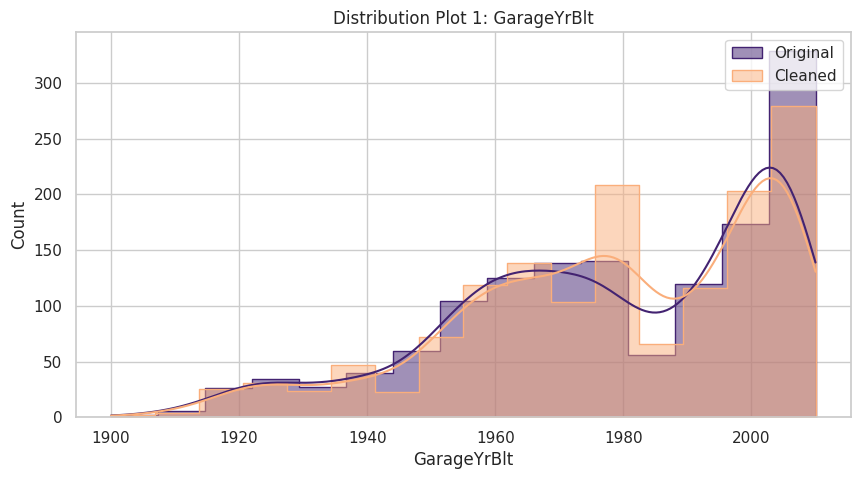

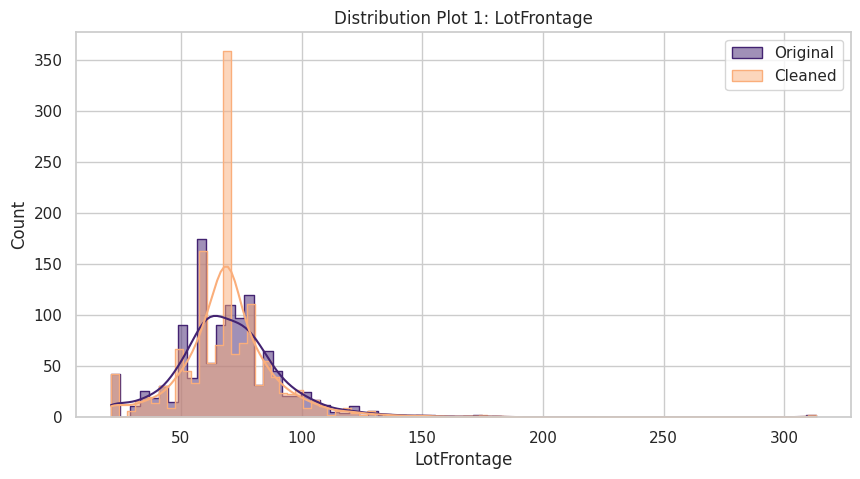

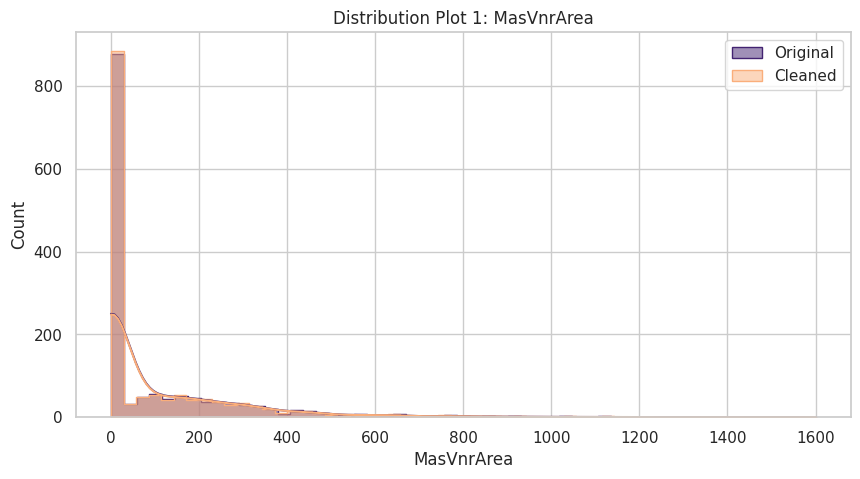

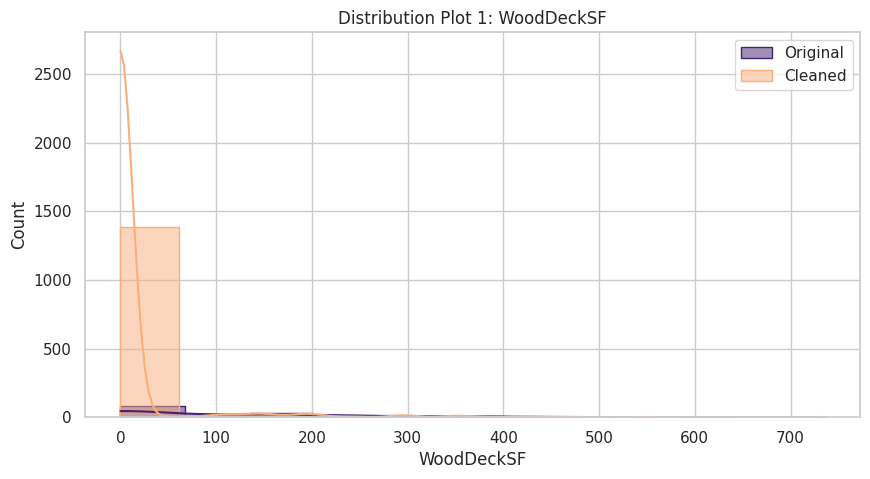

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
%matplotlib inline


def DataCleaningEffect(df_original, df_cleaned, variables_applied_with_method):

    flag_count = 1  # Indicate plot number

    # distinguish between numerical and categorical variables
    categorical_variables = (df_original.select_dtypes(exclude=['number'])
                             .columns)

    # scan over variables,
    # first on variables that you applied the method
    # if the variable is a numerical plot, a histogram if
    # categorical plot a barplot
    for set_of_variables in [variables_applied_with_method]:
        print("\n===========================================================" +
              "==========================")
        print(f"* Distribution Effect Analysis After Data Cleaning Method in" +
              " the following variables:")
        print(f"{set_of_variables} \n\n")

    for var in set_of_variables:
        if var in categorical_variables:  # it is categorical variable: barplot

            df1 = pd.DataFrame({"Type": "Original", "Value": df_original[var]})
            df2 = pd.DataFrame({"Type": "Cleaned", "Value": df_cleaned[var]})
            dfAux = pd.concat([df1, df2], axis=0)
            fig, axes = plt.subplots(figsize=(15, 5))
            sns.countplot(hue='Type', data=dfAux, x="Value",
                          palette=['#432371', "#FAAE7B"])
            axes.set(title=f"Distribution Plot {flag_count}: {var}")
            plt.xticks(rotation=90)
            plt.legend()

        else:  # it is numerical variable: histogram

            fig, axes = plt.subplots(figsize=(10, 5))
            sns.histplot(data=df_original, x=var, color="#432371",
                         label='Original', kde=True, element="step", ax=axes)
            sns.histplot(data=df_cleaned, x=var, color="#FAAE7B",
                         label='Cleaned', kde=True, element="step", ax=axes)
            axes.set(title=f"Distribution Plot {flag_count}: {var}")
            plt.legend()

    plt.show()
    flag_count += 1


DataCleaningEffect(df, df_cleaned, vars_with_missing_data)


* There is a big change in the distribution of 'EnclosedPorch' & 'WoodDeckSF'. The missing levels of these variables was very large to begin with so it could be argues that dropping them was valid. However, our rationale for imputing zero makes real world sense so we will keep thme in our cleaned dataset for now.

## Split Train and Test Set

* We will now split our cleaned data into our train and test sets

In [22]:
from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(
                                        df_cleaned,
                                        df_cleaned['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (1168, 24) 
TestSet shape: (292, 24)


* We ensure there is no missing data before we push our cleaned data to the repository

In [23]:
EvaluateMissingData(TrainSet)

,RowsWithMissingData,PercentageOfDataset,DataType


In [24]:
EvaluateMissingData(TestSet)

,RowsWithMissingData,PercentageOfDataset,DataType


# Push cleaned files to Repo

* In case you don't need to push files to Repo, you may replace this section for "Conclusions and Next Steps" and state your conclusions and next steps.

In [25]:
try:
    # Creates cleaned folder
    os.makedirs(name='outputs/datasets/cleaned')
except Exception as e:
    print(e)


[Errno 17] File exists: 'outputs/datasets/cleaned'


## Train Set

In [26]:
TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

## Test Set

In [27]:
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)